<font size="5">Применение статистической модели ARIMA</font>

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
import mplcyberpunk

plt.style.use("cyberpunk")

In [50]:
fe_df = pd.read_csv('fe_df.csv', index_col='Дата', parse_dates=True, dayfirst=True)
fe_df.sort_index(inplace=True)
fe_df["Цена"] = fe_df["Цена"].str.replace(",", ".").astype(float)

In [51]:
fe_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3403 entries, 2010-10-25 to 2024-05-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Цена    3403 non-null   float64
 1   Откр.   3403 non-null   object 
 2   Макс.   3403 non-null   object 
 3   Мин.    3403 non-null   object 
 4   Объём   542 non-null    object 
 5   Изм. %  3403 non-null   object 
dtypes: float64(1), object(5)
memory usage: 186.1+ KB


**Построим график по дням**

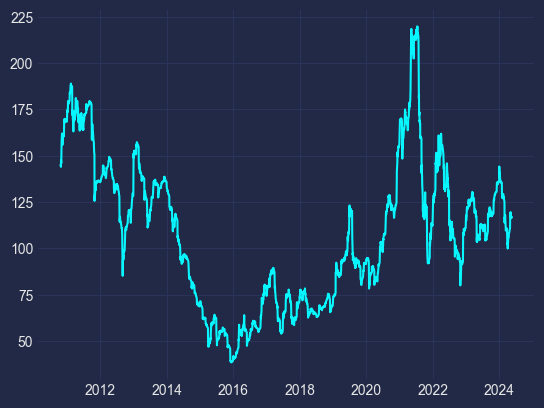

In [52]:
plt.plot(fe_df.index, fe_df["Цена"])

**Построим график по месяцам**

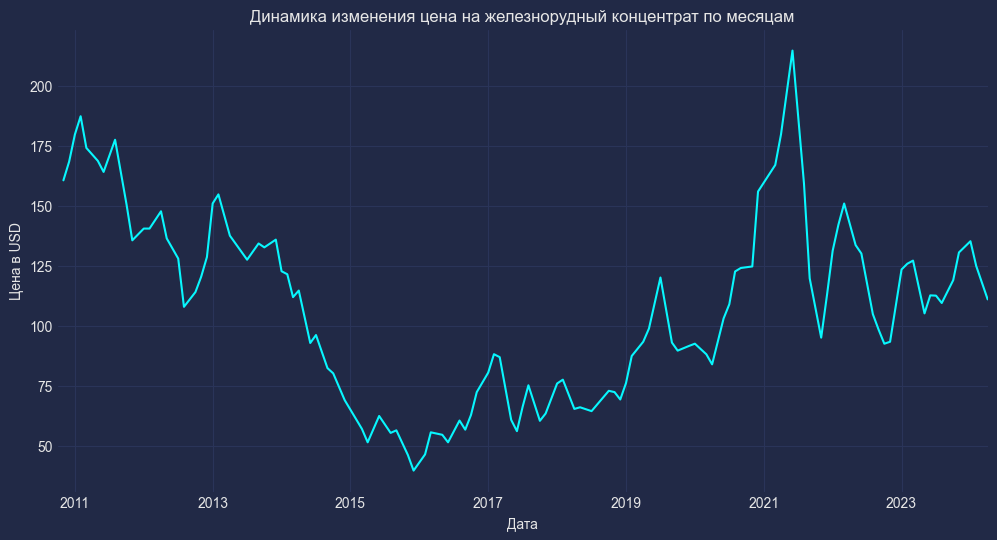

In [53]:
plt.figure(figsize=(12, 6))
fe_df["Цена"].asfreq("M").interpolate().plot()
plt.title("Динамика изменения цена на железнорудный концентрат по месяцам")
plt.ylabel("Цена в USD")

plt.show()


In [54]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

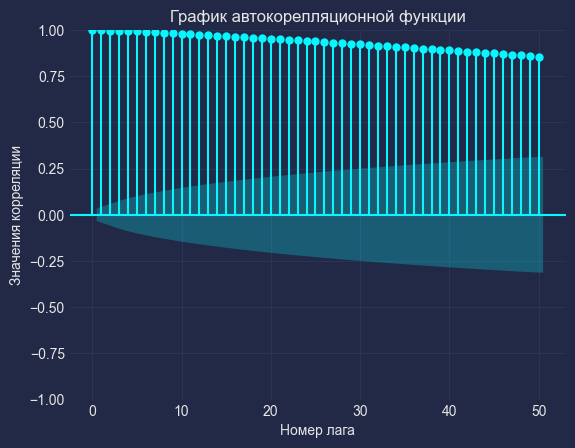

In [55]:
plot_acf(fe_df["Цена"],lags=50,title="График автокорелляционной функции")
plt.ylabel("Значения корреляции")
plt.xlabel("Номер лага")
plt.show()

Поскольку все запаздывания либо близки к 1(если рассмотреть более большой интервал), либо, по крайней мере, превышают доверительный интервал, они являются статистически значимыми

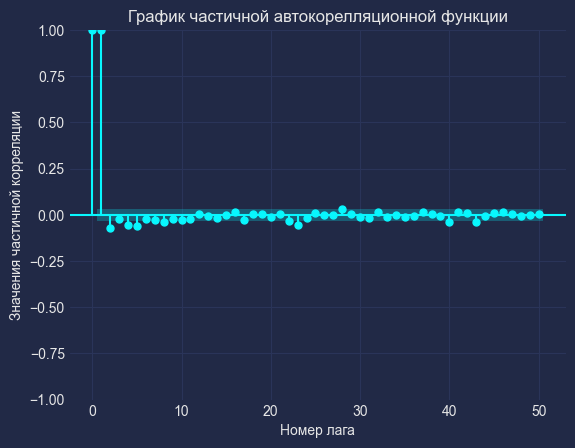

In [56]:
plot_pacf(fe_df["Цена"],lags=50,title="График частичной автокорелляционной функции")
plt.ylabel("Значения частичной корреляции")
plt.xlabel("Номер лага")
plt.show()

Хотя это статистически значимо, частичная автокорреляция после первых 2 этапов очень низкая.

Один из важнейших параметров для классической декомпозиции - это параметр two_sided. Если two_sided=True, то скользящее средние считается по точкам, находящимся как справа, так и слева, и только по точкам слева, если two_sided=False. В результате при two_sided=True вы гораздо лучше оценивает тренд (остатки выглядят как белый шум, но у вас остается незаполненными последние период 6, и для прогноза на 1 шаг вам придется экстраполировать тренд на 7 значений вперед.

<Figure size 1200x600 with 0 Axes>

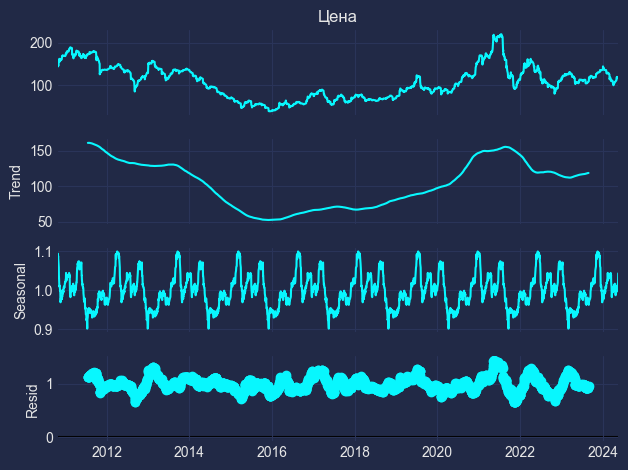

In [57]:
plt.figure(figsize=(12, 6))
decomposed_fe_df = sm.tsa.seasonal_decompose(fe_df["Цена"], period=365, model="multiplicative", two_sided=True, filt=None)
figure = decomposed_fe_df.plot()
plt.show()


Мультипликативная декомпозиция оказалась довольно эффективной, от сезонности довольно хорошо избавились.

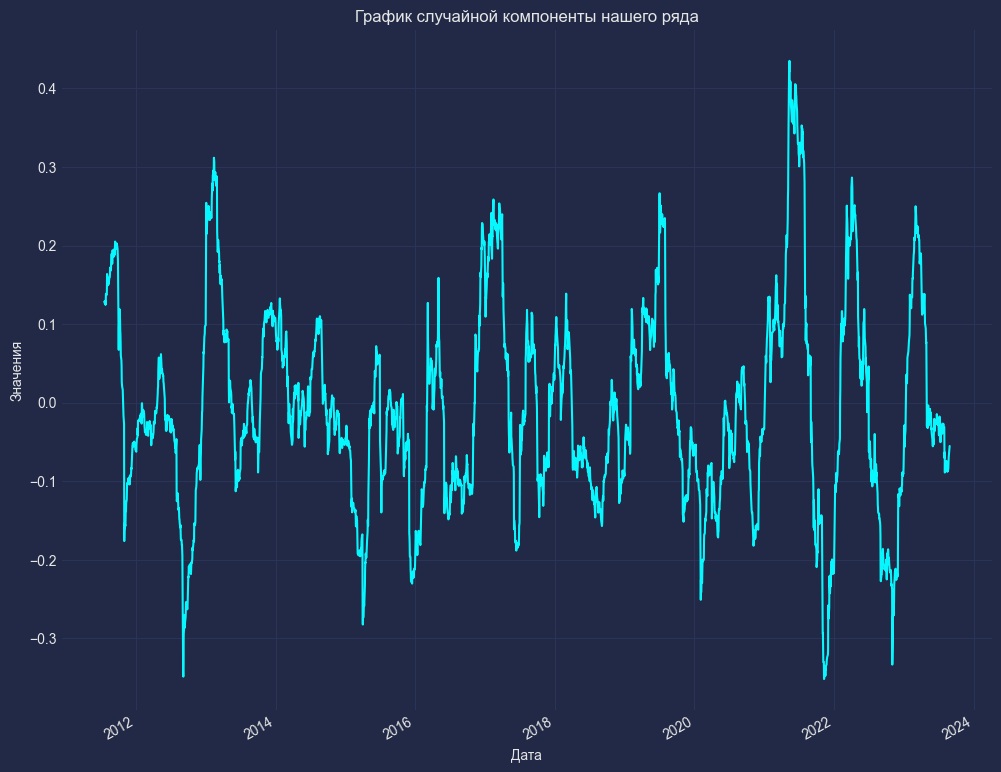

In [58]:
plt.figure(figsize=(12, 10))
(decomposed_fe_df.resid - 1).plot()
plt.title("График случайной компоненты нашего ряда")
plt.ylabel("Значения")

plt.show()

На приведенном выше графике явно нельзя утверждать тенденцию, по большей части из за того, что в 2008 году был кризис как и во время ковида в 2021. Но в целом с 2016 имеется четкая тенденция к повышению цены.
Вы также можете увидеть равномерные сезонные изменения.
Неоднородный шум, который представляет собой выбросы и пропущенные значения

Стационарный временной ряд - это такой, статистические свойства которого, такие как среднее значение, дисперсия, автокорреляция и т.д., постоянны во времени.

Сильная стационарность: это стохастический процесс, безусловное совместное распределение вероятностей которого не меняется при сдвиге во времени. Следовательно, такие параметры, как среднее значение и дисперсия, также не меняются с течением времени.
Слабая стационарность: это процесс, при котором среднее значение, дисперсия и автокорреляция остаются постоянными на протяжении всего времени.
Стационарность важна, поскольку нестационарные ряды, зависящие от времени, имеют слишком много параметров, которые необходимо учитывать при моделировании временного ряда. метод diff() позволяет легко преобразовать нестационарный ряд в стационарный.

Мы попытаемся разложить сезонную составляющую приведенного выше разложенного временного ряда.

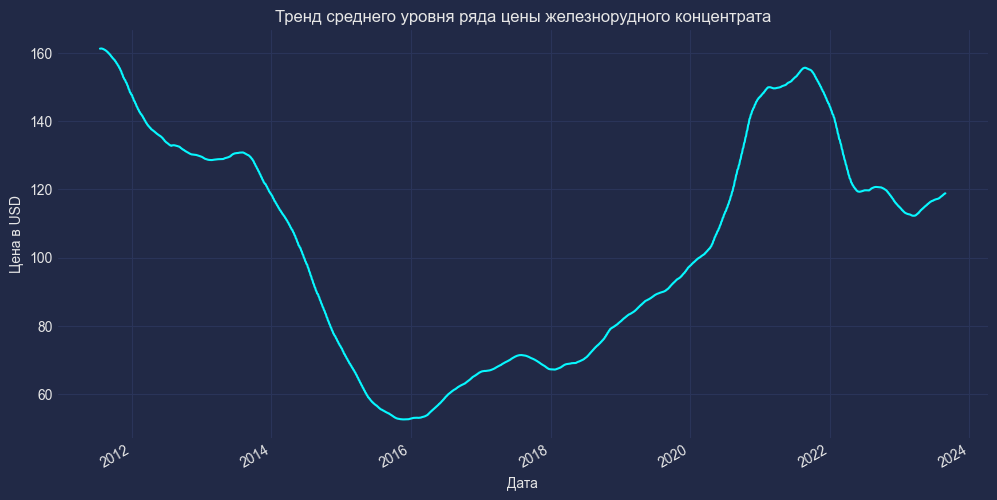

In [59]:
plt.figure(figsize=(12, 6))
decomposed_fe_df.trend.plot()
plt.title("Тренд среднего уровня ряда цены железнорудного концентрата")
plt.ylabel("Цена в USD")

plt.show()

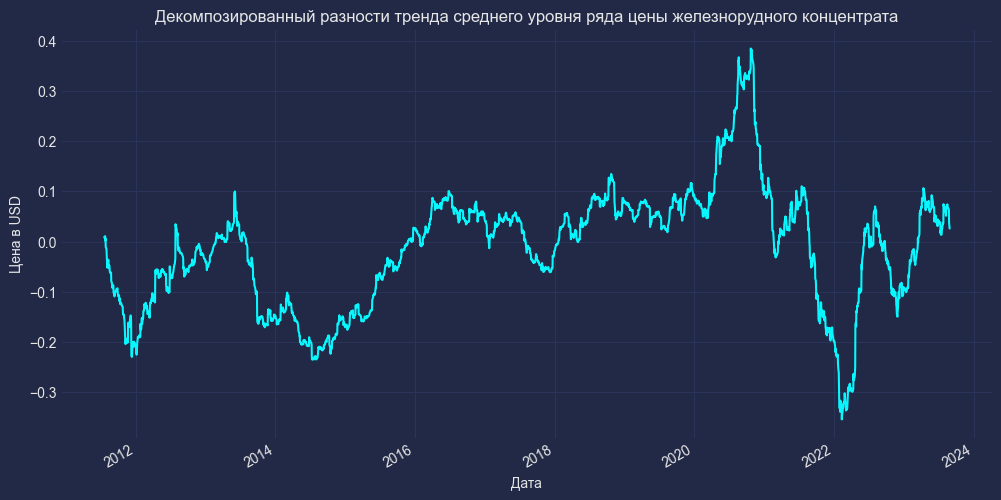

In [60]:
plt.figure(figsize=(12, 6))
decomposed_fe_df.trend.diff().plot()
plt.title("Декомпозированный разности тренда среднего уровня ряда цены железнорудного концентрата")
plt.ylabel("Цена в USD")

plt.show()

In [61]:
decomposed_fe_df.resid.dropna()

Дата
2011-07-19    1.128496
2011-07-20    1.127948
2011-07-21    1.127049
2011-07-22    1.126741
2011-07-25    1.124774
                ...   
2023-08-22    0.924509
2023-08-23    0.929640
2023-08-24    0.933622
2023-08-25    0.935993
2023-08-28    0.944742
Name: resid, Length: 3039, dtype: float64

In [62]:
sm.tsa.stattools.adfuller(decomposed_fe_df.resid.dropna())[1]

4.0898006654873654e-05

In [63]:
sm.tsa.stattools.kpss(decomposed_fe_df.resid.dropna())[1]

/var/folders/_3/mj4tngv10_g6qb1kvr8318hr0000gn/T/ipykernel_3943/796174499.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(decomposed_fe_df.resid.dropna())[1]


0.1

Согласно критерию Дики-Фуллера и KPSS ряд является стационарным.

In [64]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [65]:

train_size = int(len(fe_df) * 0.8)
train, test = fe_df[:train_size], fe_df[train_size:]

In [66]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from pmdarima import auto_arima
from scipy.stats import boxcox

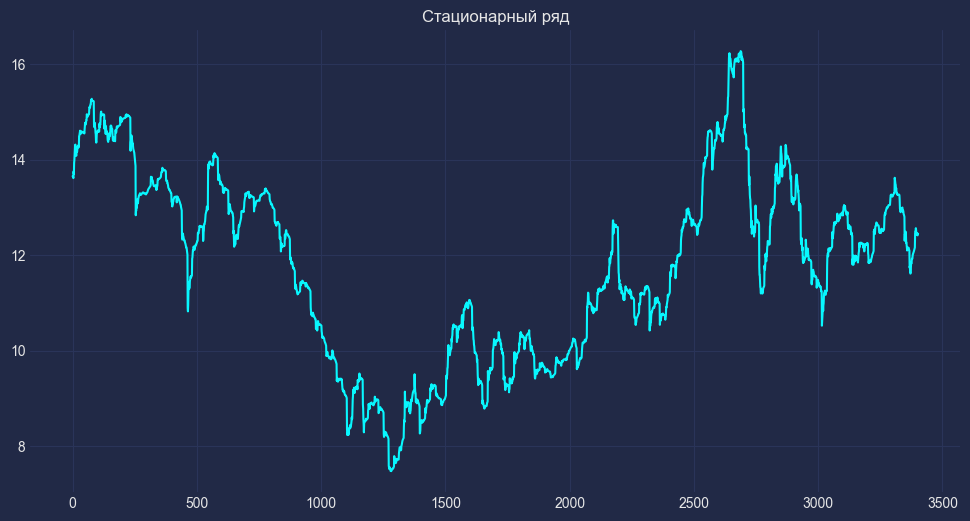

In [67]:
# Проверка стационарности и применение преобразования Бокса-Кокса при необходимости
def make_stationary(data):
    # Проверка стационарности
    result = adfuller(data)
    if result[1] > 0.05:
        # Применение преобразования Бокса-Кокса
        transformed_data, lam = boxcox(data)
        return transformed_data, lam
    else:
        return data, None

stationary_data, lam = make_stationary(fe_df['Цена'])

# Визуализация стационарного ряда
plt.figure(figsize=(12, 6))
plt.plot(stationary_data)
plt.title('Стационарный ряд')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14954.745, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14940.816, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14960.956, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14959.713, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14942.746, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14961.380, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14966.659, Time=0.54 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-14970.246, Time=0.69 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-14971.829, Time=0.76 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-14969.785, Time=0.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-14967.886, Time=0.72 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-14973.798, Time=0.57 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-14972.212, Time=0.44 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-14971.755, Time=1.03 sec
 ARIM

/Users/adtarletskiy/Documents/ШАД/ML 4.Time_series/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/adtarletskiy/Documents/ШАД/ML 4.Time_series/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAPE: 0.18851151326707039
RMSE: 26.63968596688854


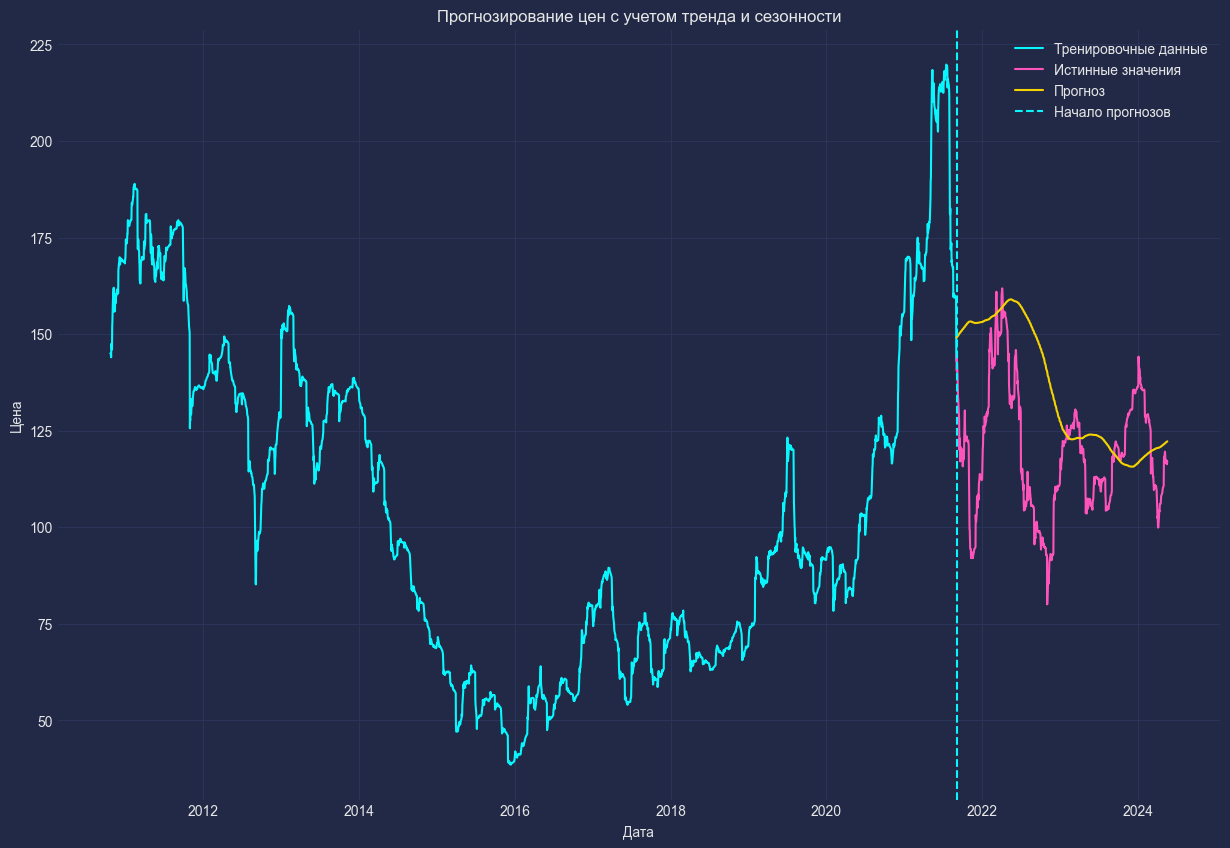

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Преобразование Бокса-Кокса для стационарности
def boxcox_transform(data):
    transformed_data, lam = boxcox(data + 1)  # Добавляем 1, чтобы избежать проблем с нулями
    return transformed_data, lam

transformed_data, lam = boxcox_transform(fe_df['Цена'])

# Декомпозиция временного ряда
decomposed_fe_df = seasonal_decompose(fe_df['Цена'], period=365, model="multiplicative", two_sided=False)
trend = decomposed_fe_df.trend
seasonal = decomposed_fe_df.seasonal
residual = decomposed_fe_df.resid

# Заполнение пропусков в тренде и остатках
trend_filled = trend.interpolate(method='linear').ffill().bfill()
residual_filled = residual.interpolate(method='linear').ffill().bfill()

# Разделение на тренировочную и тестовую выборки
train_size = int(len(residual_filled) * 0.8)
train_residual, test_residual = residual_filled[:train_size], residual_filled[train_size:]

# Автоматический подбор параметров модели ARIMA
model = auto_arima(train_residual, seasonal=True, trace=True)

# Обучение модели ARIMA
model_fit = model.fit(train_residual)

# Прогнозирование остатков
forecast_residual = model_fit.predict(n_periods=len(test_residual))
forecast_index = residual_filled.index[train_size:train_size+len(forecast_residual)]

# Прогнозирование тренда и сезонности на будущее
trend_forecast = trend_filled.iloc[train_size:train_size+len(test_residual)].values
seasonal_forecast = np.tile(seasonal[-365:].values, int(np.ceil(len(test_residual) / 365)))[:len(test_residual)]

final_forecast = trend_forecast  + seasonal_forecast + inv_boxcox(forecast_residual, lam)
forecast_df = pd.DataFrame(final_forecast.values, index=forecast_index, columns=['Прогноз'])

actual_values = fe_df['Цена'].iloc[train_size:train_size+len(forecast_df)]
if len(actual_values) != len(forecast_df['Прогноз']):
    raise ValueError("Длины тестового набора и прогнозов не совпадают.")

# Оценка модели
mape = mean_absolute_percentage_error(actual_values, forecast_df['Прогноз'])
rmse = np.sqrt(mean_squared_error(actual_values, forecast_df['Прогноз']))

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(fe_df['Цена'].iloc[:train_size], label='Тренировочные данные')
ax.plot(fe_df['Цена'].iloc[train_size:], label='Истинные значения')
ax.plot(forecast_df['Прогноз'], label='Прогноз')
ax.axvline(x=fe_df.index[train_size], linestyle='--', label='Начало прогнозов')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование цен с учетом тренда и сезонности')
plt.legend()
plt.show()

Тут просто просматриваю глазками, что получилось

In [69]:
trend_forecast

array([145.60950685, 145.76309589, 145.90115068, 146.03010959,
       146.1550411 , 146.27876712, 146.41389041, 146.5409589 ,
       146.65542466, 146.75808219, 146.87068493, 146.96421918,
       147.06191781, 147.1629863 , 147.26216438, 147.36046575,
       147.45961644, 147.55747945, 147.65410959, 147.752     ,
       147.83865753, 147.9310411 , 148.02383562, 148.11621918,
       148.2099726 , 148.31690411, 148.4440274 , 148.56435616,
       148.67432877, 148.78328767, 148.89260274, 148.99526027,
       149.09515068, 149.1959726 , 149.29208219, 149.38564384,
       149.47693151, 149.56726027, 149.65183562, 149.73756164,
       149.8200274 , 149.85120548, 149.87306849, 149.89419178,
       149.90887671, 149.91539726, 149.92038356, 149.90071233,
       149.87747945, 149.85893151, 149.844     , 149.82235616,
       149.79112329, 149.76312329, 149.73331507, 149.706     ,
       149.67805479, 149.65317808, 149.62816438, 149.60421918,
       149.58136986, 149.55926027, 149.55991781, 149.55

In [70]:
final_forecast

2722    149.078915
2723    149.232513
2724    149.365075
2725    149.489825
2726    149.608096
           ...    
3398    122.027995
3399    122.097701
3400    122.159441
3401    122.200636
3402    122.225468
Length: 681, dtype: float64

<font size="5">Применения ML-подходов - бустинга</font>

In [72]:
fe_df=fe_df[["Цена"]]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 2065, number of used features: 14
[LightGBM] [Info] Start training from score 90.108140
MAPE: 0.05
RMSE: 8.29


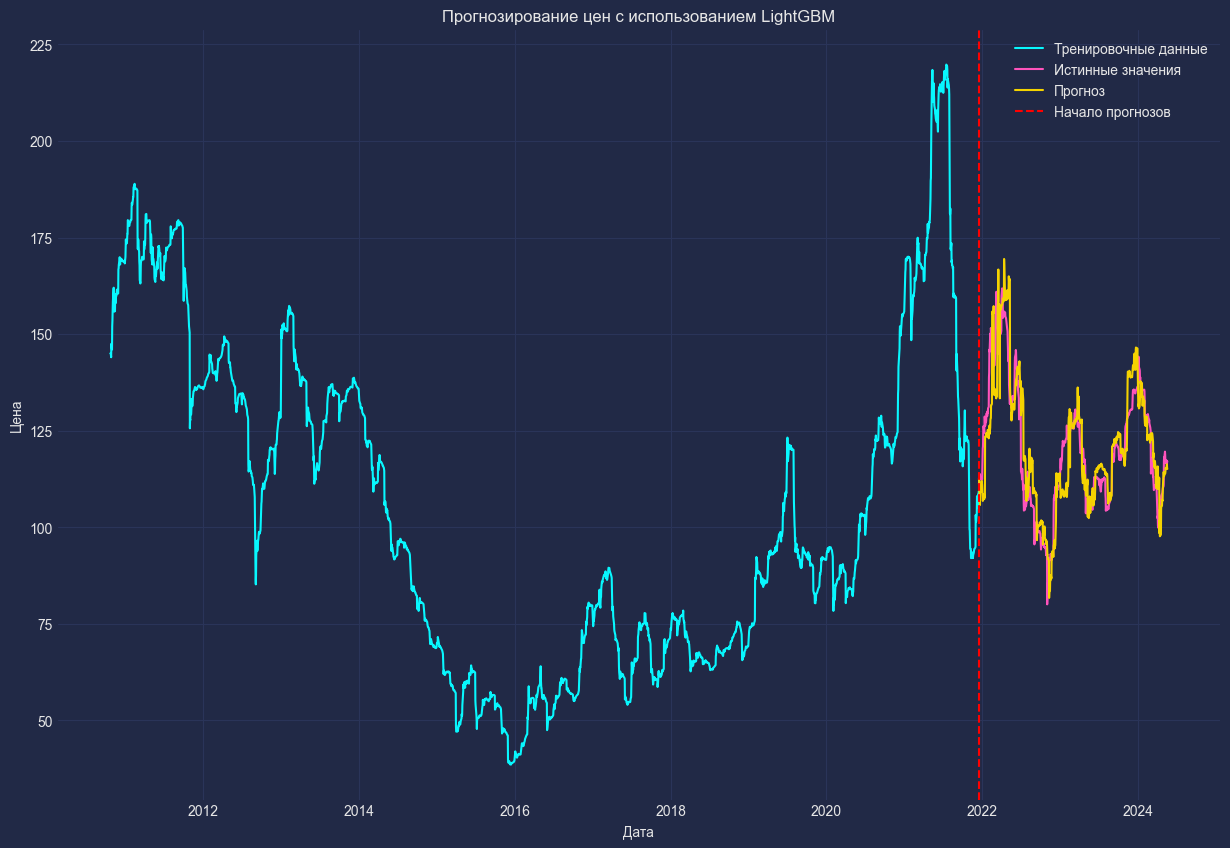

In [73]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def features_regression(df):
    dff = df.copy()
    dff['year'] = dff.index.year
    dff['month'] = dff.index.month
    dff['day_of_year'] = dff.index.dayofyear
    dff['day_of_week'] = dff.index.dayofweek

    feature_lags = [7, 14, 21, 28, 35, 42, 49, 120, 182, 365]
    for lag in feature_lags:
        dff[f'price_lag_{lag}'] = dff['Цена'].shift(periods=lag)

    return dff

def split_train_test(df, train_ratio, min_lag):
    split_t = int(len(df) * train_ratio)

    y = df['Цена']
    y_train = y[:split_t]
    y_test = y[split_t:]

    xdf = df.drop('Цена', axis=1)
    x_train = xdf[:split_t]
    x_test = xdf[split_t:]

    y_train = y_train[min_lag:]
    x_train = x_train[min_lag:]

    return x_train, y_train, x_test, y_test, split_t

def fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=100):
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=n_estimators
    )

    model.fit(
        x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='rmse'
    )

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

df_gbdt = features_regression(fe_df)

# Заполнение пропусков после добавления лагов
df_gbdt = df_gbdt.dropna()

# Учитываем максимальный лаг для корректного разделения данных
max_lag = 365
train_ratio = 0.8
x_train, y_train, x_test, y_test, split_t = split_train_test(df_gbdt, train_ratio, max_lag)

model = fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=500)

# Оценка модели
forecast = model.predict(x_test)
mape = mean_absolute_percentage_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')

# Построение графика
fig, ax = plt.subplots(1, figsize=(15, 10))
# Используем начальный DataFrame для построения тренировочных данных
ax.plot(fe_df.index[:split_t+365], fe_df['Цена'][:split_t+365], label='Тренировочные данные')
ax.plot(y_test.index, y_test, label='Истинные значения')
ax.plot(y_test.index, forecast, label='Прогноз')

ax.axvline(x=y_test.index[0], linestyle='--', color='red', label='Начало прогнозов')
ax.set_xlabel('Дата')
ax.set_ylabel('Цена')
ax.set_title('Прогнозирование цен с использованием LightGBM')
ax.legend()
plt.show()


Теперь расмотрим главную проблему light gbm если мы попытаемся уменьшить к примеру долю train до 50%. Сразу видна проблема невозможности эксраполяции предсказаний

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 14
[LightGBM] [Info] Start training from score 73.702669
MAPE: 0.11
RMSE: 25.19


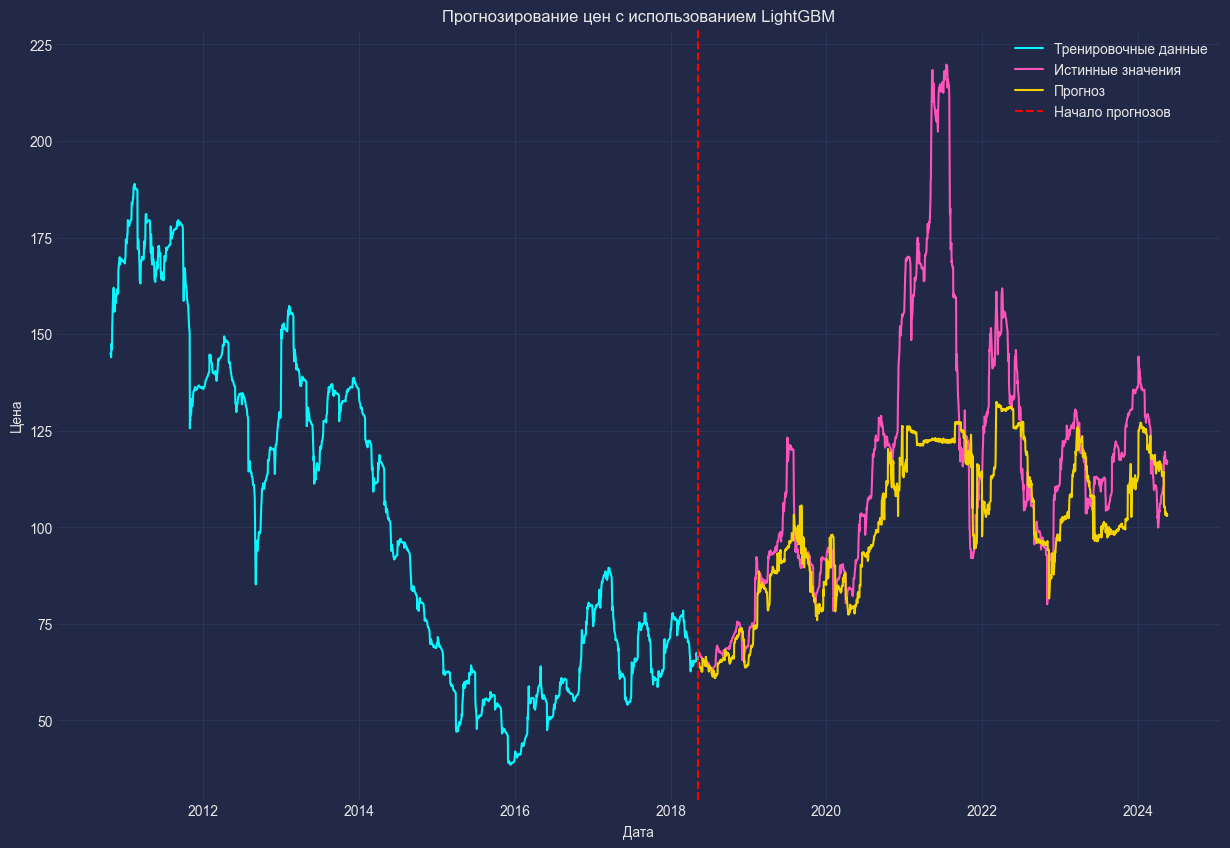

In [81]:
# Учитываем максимальный лаг для корректного разделения данных
max_lag = 365
train_ratio = 0.5
x_train, y_train, x_test, y_test, split_t = split_train_test(df_gbdt, train_ratio, max_lag)

model = fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=500)

# Оценка модели
forecast = model.predict(x_test)
mape = mean_absolute_percentage_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')

# Построение графика
fig, ax = plt.subplots(1, figsize=(15, 10))
# Используем начальный DataFrame для построения тренировочных данных
ax.plot(fe_df.index[:split_t+365], fe_df['Цена'][:split_t+365], label='Тренировочные данные')
ax.plot(y_test.index, y_test, label='Истинные значения')
ax.plot(y_test.index, forecast, label='Прогноз')

ax.axvline(x=y_test.index[0], linestyle='--', color='red', label='Начало прогнозов')
ax.set_xlabel('Дата')
ax.set_ylabel('Цена')
ax.set_title('Прогнозирование цен с использованием LightGBM')
ax.legend()
plt.show()

Как видим сдвиг(условно лаг) наших предсказаний сдвинулся относительно истинных значений, а также увеличились ошибки RMSE и MAPE, но самое главное тут показано, что наш метод прогнозирования - бустинг не могет в интерполяцию, отсюда он и не захватывает пик в районе 2021, поскольку он не видел таких значений, в этом главная погрешность табличных алгоритмов.

**Итог**

    ARIMA может превосходить градиентный бустинг на простых и линейных временных рядах.
    Методы градиентного бустинга, такие как LightGBM, часто показывают лучшие результаты на сложных и нелинейных временных рядах.
    Рекомендуется экспериментировать с обеими моделями и выбирать на основе метрик производительности и специфики данных.